SBA paper: exploration of correlations between loan amount, salary, geography, business size and type

Initial definitions

In [ ]:
import glob
import pandas as pd
import zipfile
from plotnine import *    # python lib to use ggplot
import numpy as np
# libs for regression
import statsmodels.api as sm
from patsy import dmatrices
    
naics = 'NAICS3'   # or 'NAICS2'
scope = 'US'  # 'NE' for New England or 'US'

if scope == 'NE':
    NEstates = ['CT','MA','ME','NH','RI','VT']
    NEstfips = ['09','25','23','33','44','50']

def OverrideNAICS2(df):
    # adjusts 2-digit NAICS that are joint, e.g. NAICS 31-33 Manufacturing
    df.loc[df['NAICS2'].eq('31'),'NAICS2'] = '31-33'
    df.loc[df['NAICS2'].eq('33'),'NAICS2'] = '31-33'
    df.loc[df['NAICS2'].eq('44'),'NAICS2'] = '44-45' # NAICS 44-45 Retail trade
    df.loc[df['NAICS2'].eq('45'),'NAICS2'] = '44-45' # NAICS 44-45 Retail trade
    df.loc[df['NAICS2'].eq('48'),'NAICS2'] = '48-49' # 	NAICS 48-49 Transportation and warehousing
    df.loc[df['NAICS2'].eq('49'),'NAICS2'] = '48-49' # 	NAICS 48-49 Transportation and warehousing
    return df

read PPP loan data

In [ ]:
fpath = '/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/120120 Paycheck Protection Program Data/'
#fpath = '/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/03-03-21 Paycheck Protection Program Data/'

csv_files = glob.glob(fpath + '*.csv')

list_df = []
for csv_file in csv_files:
    print(csv_file)
    df = pd.read_csv(csv_file, dtype={'Zip':'object', 'NAICSCode':'object'})
    # do df manipulations
    list_df.append(df)

df = pd.concat(list_df)
loans = df.assign( NAICS2 = df.NAICSCode.str.slice(start=0, stop=2)
               , NAICS3 = df.NAICSCode.str.slice(start=0, stop=3) )

/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/120120 Paycheck Protection Program Data/04 PPP sub 150k through 112420.csv
/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/120120 Paycheck Protection Program Data/150k plus PPP through 112420.csv
/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/120120 Paycheck Protection Program Data/01 PPP sub 150k through 112420.csv
/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/120120 Paycheck Protection Program Data/02 PPP sub 150k through 112420.csv
/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/120120 Paycheck Protection Program Data/03 PPP sub 150k through 112420.csv
/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/120120 Paycheck Protection Program Data/05 PPP sub 150k through 112420.csv


Some filtering

In [ ]:
# First round of PPP only
loans['DateApproved'] = pd.to_datetime( loans['DateApproved'] )
loans = loans[loans['DateApproved'] < '2020-09-01']

# should keep loan data for New England only?
if scope == 'NE':
    loans = loans[loans['State'].isin(NEstates)]

# for compatibility with previous column names
#loans = loans.rename(columns={'InitialApprovalAmount':'LoanAmount','BorrowerZip':'Zip'})

# keep loan data for New England only
nloans = loans.shape[0]
totAmnt = loans['LoanAmount'].sum()
print(scope, 'PPP loans:{0:,.0f}'.format(nloans) )
print(scope, 'Total PPP loan Amount:', totAmnt)
print(scope, 'PPP loans with valid NAICS:', loans[~loans.NAICSCode.isna()].shape[0] / nloans )
print(scope, 'PPP loans with non-empty Zipcode:', loans[~loans.Zip.str.strip().eq('')].shape[0] / nloans )
print(scope, 'PPP loans with non-empty BusinessType:', loans[~loans.BusinessType.str.strip().eq('')].shape[0] / nloans )
print(scope, 'PPP loans with answered RaceEthnicity:', loans[~loans.RaceEthnicity.str.strip().eq('Unanswered')].shape[0] / nloans )
#print(scope, 'PPP loans with answered Race:', loans[~loans.Race.str.strip().eq('Unanswered')].shape[0] / nloans )
#print(scope, 'PPP loans with answered Ethnicity:', loans[~loans.Ethnicity.str.strip().eq('Unanswered')].shape[0] / nloans )
print(scope, 'PPP loans with answered Gender:', loans[~loans.Gender.str.strip().eq('Unanswered')].shape[0] / nloans )
print(scope, 'PPP loans with answered Veteran:', loans[~loans.Veteran.str.strip().eq('Unanswered')].shape[0] / nloans )
print(scope, 'PPP loans with answered NonProfit:', loans[~loans.NonProfit.isna()].shape[0] / nloans )

loans.to_csv('/Users/aligo/Box/1 RisknDecScience/FEMA recovery/SBA paper/data/PPPloans' + scope + '.csv')
#if scope == 'US':
#    loans.sample(n=500000, random_state=1).to_csv(
#    '/Users/aligo/Box/1 RisknDecScience/FEMA recovery/SBA paper/data/PPPloansSAMPLE_' + scope + '.csv')

tmp = loans['State'].unique()
tmp = np.sort(loans[~loans['State'].isna()]['State'].unique())
tmp = np.sort(loans[loans['LoanAmount'].le(150e3) & ~loans['State'].isna()]['State'].unique())
tmp = np.sort(loans[loans['LoanAmount'].gt(150e3) & ~loans['State'].isna()]['State'].unique())

US PPP loans:5,156,850
US Total PPP loan Amount: 522949800493.81824
US PPP loans with valid NAICS: 0.9742206967431668
US PPP loans with non-empty Zipcode: 1.0
US PPP loans with non-empty BusinessType: 1.0
US PPP loans with answered RaceEthnicity: 0.10391188419286967
US PPP loans with answered Gender: 0.21402755558141112
US PPP loans with answered Veteran: 0.14601180953489049
US PPP loans with answered NonProfit: 0.035122797832009854


list and save Loans' business types

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


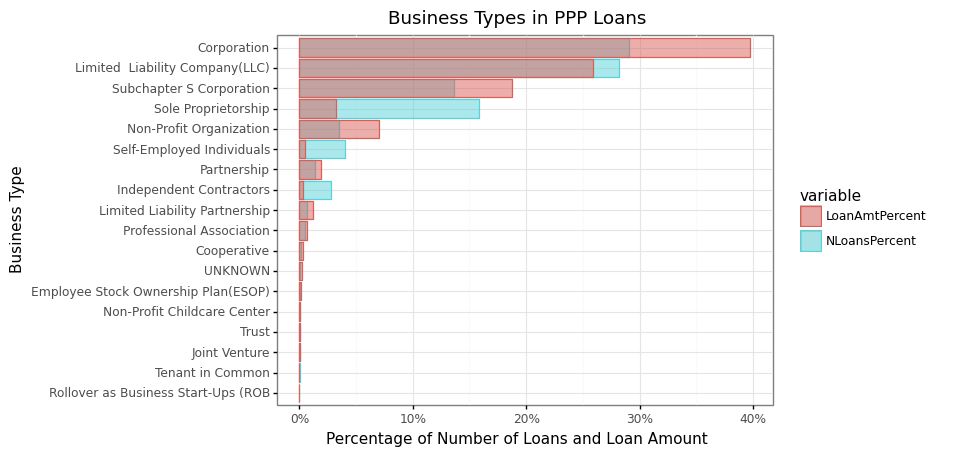

<ggplot: (8766442040729)>

In [ ]:
biztypes = loans.groupby('BusinessType').agg({'State':'count','LoanAmount':'sum'})
idx = loans['BusinessType'].isna()
biztypes.loc['UNKNOWN'] = [idx.sum(), loans.loc[idx,'LoanAmount'].sum()]
biztypes['NLoansPercent'] = biztypes['State'] / nloans
biztypes['LoanAmtPercent'] = biztypes['LoanAmount'] / totAmnt
biztypes = biztypes[['NLoansPercent','LoanAmtPercent']].reset_index().melt(id_vars=['BusinessType'])

ggplot(biztypes, aes(x='reorder(BusinessType,value)', y='value',color='variable',fill='variable')
          ) + geom_bar(stat="identity", position ="identity",alpha=0.5
#          ) + scale_alpha_manual(values=[.1, .3]
          ) + theme_bw(
          ) + xlab('Business Type'
          ) + ylab('Percentage of Number of Loans and Loan Amount'
          ) + ggtitle('Business Types in PPP Loans'
          ) + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]
          ) + coord_flip()
#fpath = '/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/'
#with pd.ExcelWriter(fpath + 'PPP_business_types.xlsx') as writer:
#    biztypes[['NLoansPercent','LoanAmtPercent']].to_excel(writer, sheet_name='PPP', index=True)


plot race

                       RaceEthnicity        variable         value
0   American Indian or Alaska Native   NLoansPercent  5.354030e-03
1                              Asian   NLoansPercent  1.093219e-01
2          Black or African American   NLoansPercent  3.200475e-02
3                     Eskimo & Aleut   NLoansPercent  9.330830e-06
4                           Hispanic   NLoansPercent  7.780233e-02
5                        Multi Group   NLoansPercent  1.866166e-05
6                       Puerto Rican   NLoansPercent  2.948542e-04
7                              White   NLoansPercent  7.751942e-01
8   American Indian or Alaska Native  LoanAmtPercent  6.637840e-03
9                              Asian  LoanAmtPercent  8.073428e-02
10         Black or African American  LoanAmtPercent  2.180519e-02
11                    Eskimo & Aleut  LoanAmtPercent  6.536777e-07
12                          Hispanic  LoanAmtPercent  6.494665e-02
13                       Multi Group  LoanAmtPercent  3.786388

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


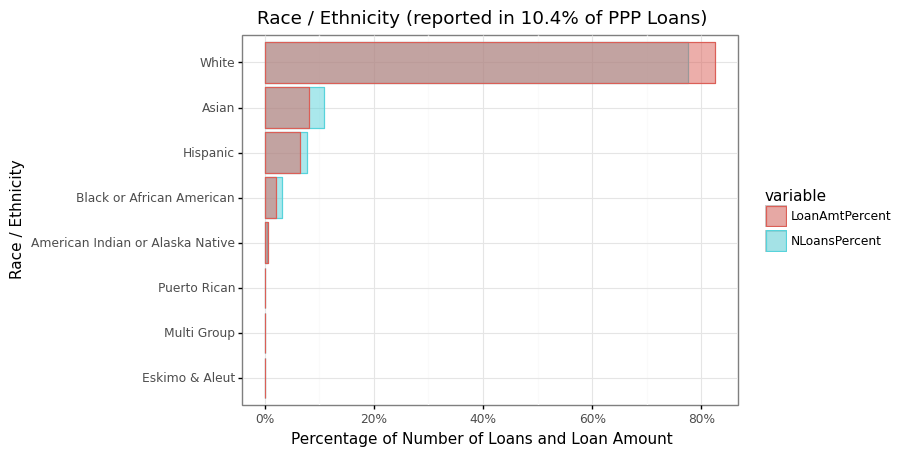

<ggplot: (8766820708257)>

In [ ]:
race = loans[~loans.RaceEthnicity.str.strip().eq('Unanswered')].groupby('RaceEthnicity'
                                    ).agg({'State':'count','LoanAmount':'sum'})
race['NLoansPercent'] = race['State'] / race['State'].sum()
race['LoanAmtPercent'] = race['LoanAmount'] / race['LoanAmount'].sum()
race = race[['NLoansPercent','LoanAmtPercent']].reset_index().melt(id_vars=['RaceEthnicity'])
print(race)
ggplot(race, aes(x='reorder(RaceEthnicity,value)', y='value',color='variable',fill='variable')
          ) + geom_bar(stat="identity", position ="identity",alpha=0.5
          ) + theme_bw(
          ) + xlab('Race / Ethnicity'
          ) + ylab('Percentage of Number of Loans and Loan Amount'
          ) + ggtitle('Race / Ethnicity (reported in 10.4% of PPP Loans)'
          ) + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]
          ) + coord_flip()

plot gender

         Gender        variable     value
0  Female Owned   NLoansPercent  0.229497
1    Male Owned   NLoansPercent  0.770503
2  Female Owned  LoanAmtPercent  0.163971
3    Male Owned  LoanAmtPercent  0.836029


/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


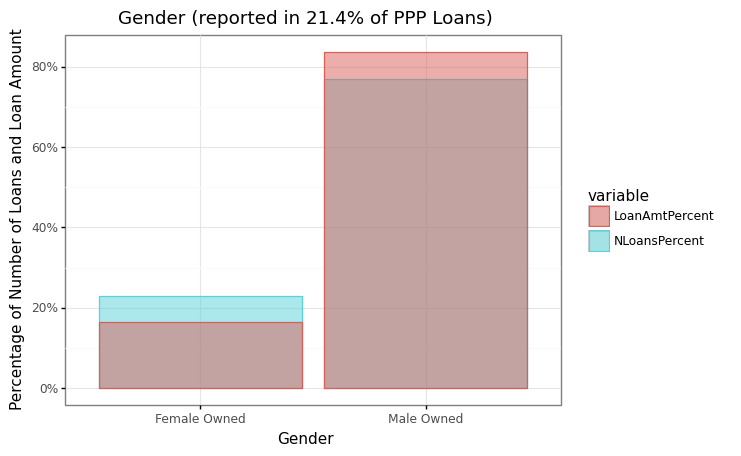

<ggplot: (8766441797453)>

In [ ]:
gender = loans[~loans.Gender.str.strip().eq('Unanswered')].groupby('Gender'
                                    ).agg({'State':'count','LoanAmount':'sum'})
gender['NLoansPercent'] = gender['State'] / gender['State'].sum()
gender['LoanAmtPercent'] = gender['LoanAmount'] / gender['LoanAmount'].sum()
gender = gender[['NLoansPercent','LoanAmtPercent']].reset_index().melt(id_vars=['Gender'])
print(gender)
ggplot(gender, aes(x='reorder(Gender,value)', y='value',color='variable',fill='variable')
          ) + geom_bar(stat="identity", position ="identity",alpha=0.5
          ) + theme_bw(
          ) + xlab('Gender'
          ) + ylab('Percentage of Number of Loans and Loan Amount'
          ) + ggtitle('Gender (reported in 21.4% of PPP Loans)'
          ) + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]
          ) 

plot veteran status

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


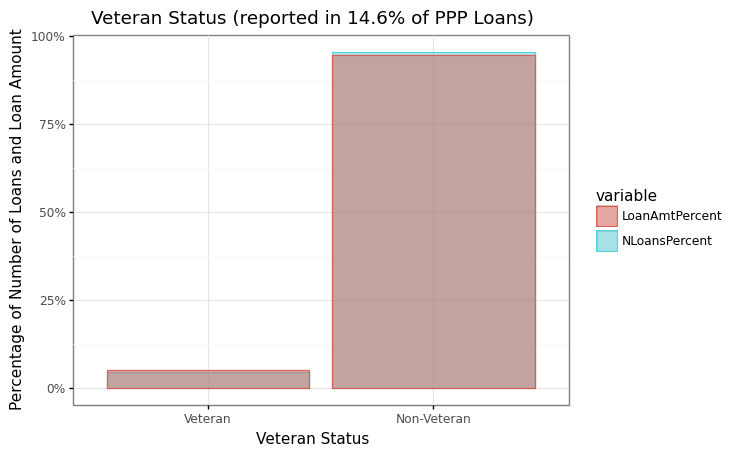

<ggplot: (8766441817661)>

In [ ]:
veteran = loans[~loans.Veteran.str.strip().eq('Unanswered')].groupby('Veteran'
                                    ).agg({'State':'count','LoanAmount':'sum'})
veteran['NLoansPercent'] = veteran['State'] / veteran['State'].sum()
veteran['LoanAmtPercent'] = veteran['LoanAmount'] / veteran['LoanAmount'].sum()
veteran = veteran[['NLoansPercent','LoanAmtPercent']].reset_index().melt(id_vars=['Veteran'])

ggplot(veteran, aes(x='reorder(Veteran,value)', y='value',color='variable',fill='variable')
          ) + geom_bar(stat="identity", position ="identity",alpha=0.5
          ) + theme_bw(
          ) + xlab('Veteran Status'
          ) + ylab('Percentage of Number of Loans and Loan Amount'
          ) + ggtitle('Veteran Status (reported in 14.6% of PPP Loans)'
          ) + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]
          )

## Exclude loans to sole proprietors, contractors etc

In [ ]:
soleprop = ['Independent Contractors' #,'Self-Employed Individuals'
            ,'Sole Proprietorship', 'Tenant in Common']
loansCorp = loans[~loans.BusinessType.isin(soleprop)]
print(loansCorp.shape[0], 'loans in PPP dataset excluding', soleprop)

4194074 loans in PPP dataset excluding ['Independent Contractors', 'Sole Proprietorship', 'Tenant in Common']


# Join County info into each loan 

In [ ]:
loansc = loansCorp.reset_index().drop(columns='index')
loansc['cityc'] = loansc['City'].str.upper()
# clean 'city', 'town' etc from city name
remove_words = ['TOWN', 'CITY', 'PLANTATION','CCD','TOWNSHIP','PRECINCT','BOROUGH','DISTRICT']
patremove = r'\b(?:{})\b'.format('|'.join(remove_words))
loansc['cityc'] = loansc['cityc'].str.replace(patremove, '',regex=True).str.strip()
# remove whitespaces
loansc['cityc'] = loansc['cityc'].str.replace(r'[^A-Z ]+','',regex=True).str.strip()

loancities = loansc[['State','cityc']].drop_duplicates().reset_index().drop(
                        columns='index').rename(columns={'State':'StateAbb'})
tmp = loansc.rename(columns={'State':'StateAbb'}).set_index(['StateAbb','cityc'])
tmp = tmp[~tmp.index.duplicated(keep='first')]
loancities = loancities.set_index(['StateAbb','cityc']).join(tmp[['City','Address','Zip']])

#'https://www2.census.gov/geo/docs/maps-data/data/comp/cousub_comparabilityxls.zip'
fpath = '/Users/aligo/Downloads/FEMA recovery data/'
zf = zipfile.ZipFile( fpath + 'cousub_comparabilityxls.zip') 
citycounty = pd.read_excel(zf.open('Cousub_comparability.xlsx'), engine='openpyxl'
                           , dtype={'STATEFP10':'object','COUNTYFP10':'object'})
citycounty = citycounty[#citycounty.STATEFP10.isin(NEstfips) &
                ~citycounty['NAMELSAD10'].eq('County subdivisions not defined')]
# state abbreviations
stabbr = pd.read_csv(fpath + 'state_fips_names.csv', dtype='str')
stabbr[' st'] = stabbr[' st'].str.strip()
stabbr[' stusps'] = stabbr[' stusps'].str.strip()
stabbr = stabbr.set_index(' st').rename(columns={' stusps':'StateAbb'})
citycounty = citycounty.set_index('STATEFP10').join(stabbr).reset_index().rename(
                                                columns={"index": "STATEFP10"} )

citycounty['COUNTYName'] = citycounty['FULLNAMELSAD10'].str.extract('(, .*(?= County,))')
citycounty['COUNTYName'] = citycounty['COUNTYName'].str[2:]

# clean 'city', 'town' etc from city name
citycounty['cityc'] = citycounty['NAMELSAD10'].str.upper().str.replace(
                                        patremove, '',regex=True).str.strip()

tmp = citycounty.set_index(['StateAbb','cityc'])
tmp = tmp[~tmp.index.duplicated(keep='last')]
loancities = loancities.join(tmp)[['City','STATEFP10','COUNTYFP10','NAMELSAD10'
                                   ,'FULLNAMELSAD10','COUNTYName']].reset_index()
print('unique cities in loan dataset: ' + str(loancities.shape[0]))
print('Unique matches: ' + str(loancities['COUNTYName'].notna().sum()))
print('Unique non-matches: ' + str(loancities['COUNTYName'].isna().sum()))
loancities.to_excel('/Users/aligo/Downloads/tmp/ppp addresses.xlsx')

loancities['COUNTYfips'] = loancities['STATEFP10'] + loancities['COUNTYFP10']
tmp = loansc.rename(columns={'State':'StateAbb'}).set_index(['StateAbb','cityc'])
tmp2 = loancities.set_index(['StateAbb','cityc'])[['COUNTYfips','COUNTYName']]
loansc = tmp.join(tmp2)
print('loans in loan dataset: ' + str(loansc.shape[0]))
print('loans with matches: ' + str(loansc['COUNTYName'].notna().sum()))
print('loans non-matches: ' + str(loansc['COUNTYName'].isna().sum()))

# ZIPcode to County Code crosswalk from https://www.huduser.gov/portal/datasets/usps_crosswalk.html#data
zipcounty = pd.read_excel('/Users/aligo/Downloads/FEMA recovery data/ZIP_COUNTY_092020.xlsx'
                      , engine='openpyxl', usecols=['ZIP','COUNTY','TOT_RATIO']
                , dtype={'ZIP':'object','COUNTY':'object','TOT_RATIO':'float64'})
#zipcounty = zipcounty.reset_index()
nzc = zipcounty.shape[0]
print('zip-county pairs in US: ' + str(nzc))
zipcounty['maxtot'] = zipcounty.groupby(['ZIP'])['TOT_RATIO'].transform(max)
zipcounty = zipcounty[zipcounty['TOT_RATIO']==zipcounty['maxtot']].drop(
                                                columns=['TOT_RATIO','maxtot'])
zipcounty = zipcounty.drop_duplicates(subset='ZIP',keep='first')

nz = zipcounty.shape[0]
print('zip-county pairs in US, deduplicated: ' + str(zipcounty.shape[0]))

# County code to county name crosswalk
tmp = citycounty.assign( COUNTY = citycounty['STATEFP10'] + citycounty['COUNTYFP10'] )
#countyfips = tmp[['COUNTY','StateAbb','COUNTYName']].drop_duplicates()
countyfips = tmp[['COUNTY','StateAbb','COUNTYName']].drop_duplicates(subset='COUNTY'
                                                                ,keep='first')
countyfips.columns=['COUNTY','State','COUNTYName']

zipcounty = zipcounty.set_index('COUNTY').join(
                                countyfips.set_index('COUNTY')).reset_index()
#zipcounty = zipcounty.drop(columns=['index'])
zipcounty.columns=['COUNTYfips','Zip','State','COUNTYName']

zipcounty = zipcounty[['Zip','State','COUNTYfips','COUNTYName']].set_index('Zip')

tmp = loansc.reset_index()
loans_y = tmp[tmp['COUNTYName'].notna()]  # already matched
loans_n = tmp[tmp['COUNTYName'].isna()]  # not yet matched
cols = loans_y.columns

#loansc = loans.join(zipcounty['COUNTYfips']).reset_index() # loans with County fips and name
tmp = loans_n.set_index('Zip').drop(columns=['COUNTYfips','COUNTYName'])
m = tmp.join(zipcounty[['COUNTYfips','COUNTYName']]).reset_index()
loansc = pd.concat([loans_y[cols], m[cols]])

# tmp3 = zipcounty[['COUNTYfips','COUNTYName']].groupby('Zip').agg('count').sort_values(by='COUNTYfips', ascending=False, na_position='last')

print('loans in loan dataset: ' + str(loansc.shape[0]))
print('loans with matches: ' + str(loansc['COUNTYName'].notna().sum()))
print('loans non-matches: ' + str(loansc['COUNTYName'].isna().sum()))

# Exclude loans with unmatched county
#loansc = loansc[loansc['COUNTYName'].notna()]   

unique cities in loan dataset: 44718
Unique matches: 12108
Unique non-matches: 32610
loans in loan dataset: 4194074
loans with matches: 2367284
loans non-matches: 1826790
zip-county pairs in US: 54193
zip-county pairs in US, deduplicated: 39455
loans in loan dataset: 4194074
loans with matches: 4035596
loans non-matches: 158478


#### adjusts 2-digit NAICS that are joint, e.g. NAICS 31-33 Manufacturing

In [ ]:
if (naics == 'NAICS2'):
    loansc = OverrideNAICS2(loansc)

# check
tmp = loansc[loansc['COUNTYfips'].eq('50017')    # orange county
             & loansc['NAICS3'].eq('311')]
tmp = loansc[loansc['StateAbb'].eq('VT')   
             & loansc['NAICS3'].eq('311')]
tmp['LoanAmount'].sum()

20427025.92

#### Number of loans per county and NAICS sector

In [ ]:
loansum = loansc.groupby(['COUNTYfips',naics]).agg({'Zip':'count'
                                ,'LoanAmount':'sum', 'JobsReported':'sum'})
loansum.columns=['NLoans','TotLoanAmount','TotJobsReported']

# TOTAL NUMBER OF BUSINESSES FROM BLS
## read total number of businesses from BLS

In [ ]:
fpath = '/Users/aligo/Downloads/FEMA recovery data/'
zf = zipfile.ZipFile( fpath + '2020_qtrly_singlefile.zip') 
qcew = pd.read_csv(zf.open('2020.q1-q2.singlefile.csv'), dtype={'area_fips':'object'})
# filter
idx = (qcew.own_code.eq(5) & qcew.qtr.eq(1)  # private, FIRST quarter only
         & qcew['area_fips'].isin(countyfips['COUNTY'].tolist())
         #& ~qcew['area_fips'].str[-3:].eq('000') # exclude US total and states totals
         )
if scope == 'NE':
    idx = idx & qcew['area_fips'].str[:2].isin(NEstfips)
    
if (naics == 'NAICS2'):
    idx = idx & ((qcew['industry_code'].str.len().eq(2)   # 2-digit NAICS
            | qcew['industry_code'].str.match('\d\d-\d\d'))    # 2-digit NAICS that are joint, e.g. NAICS 31-33 Manufacturing
          & ~qcew['industry_code'].eq('10') )      # exclude code = 10 that are "ALL Naics" totals
else:
    idx = idx & (qcew['industry_code'].str.len().eq(3)   # 3-digit NAICS
          & ~qcew['industry_code'].str.startswith('10') )      # exclude code = 10 that are "ALL Naics" totals
    
cnt = qcew[idx]  
cnt = cnt[['area_fips','industry_code','qtrly_estabs','total_qtrly_wages','avg_wkly_wage']]
# Add state and county name
cnt = cnt.set_index('area_fips').join(countyfips.set_index('COUNTY')).reset_index()
# Join Total Num businesses + Num of loans
cnt.columns = ['COUNTYfips',naics,'NEstabs','total_qtrly_wages','avg_wkly_wage','State','COUNTYName']
cnt = cnt.set_index(['COUNTYfips',naics])

### Calculate loan penetration

In [ ]:
tmp = loansum.reset_index().set_index(['COUNTYfips',naics])
pen = cnt.join(loansum) #, rsuffix='loan')
pen = pen.assign(TotQtrWagesperEstab = pen['total_qtrly_wages']/pen['NEstabs']
                 , penetration = pen['NLoans']/pen['NEstabs']
                 , AvgLoanAmount = pen['TotLoanAmount']/pen['NLoans']
                 , AvgJobsReported = pen['TotJobsReported']/pen['NLoans']
                 , LoanAmtperEmp = pen['TotLoanAmount']/pen['TotJobsReported'] )
pen = pen.assign( logTotQtrWagesperEstab = np.log(pen['TotQtrWagesperEstab'])
                , logAvgLoanAmount = np.log(pen['AvgLoanAmount']) )

# Add NAICS descriptions
# naics codes downloaded from https://data.bls.gov/cew/doc/titles/industry/industry_titles.csv
fpath = '/Users/aligo/git-repos/FEMA/BLS_data/'
dfnaics = pd.read_csv(fpath + 'industry_titles.csv')

if (naics == 'NAICS2'):
    idx = (dfnaics['industry_code'].str.len().eq(2)
            | dfnaics['industry_code'].str.contains('^[0-9][0-9]-[0-9][0-9]'))
else:
    idx = dfnaics['industry_code'].str.len().eq(3)
dfnaics = dfnaics[idx]
dfnaics['industry_title'] = dfnaics['industry_title'].str.replace('^NAICS \d+ '
                    ,'',regex=True).str.replace('^NAICS \d\d-\d\d ','',regex=True)
dfnaics.columns = [naics,'NAICSdescr']
pen = pen.reset_index().set_index(naics).join(dfnaics.set_index(naics)).reset_index()

# For saving 
fpath = '/Users/aligo/Box/1 RisknDecScience/FEMA recovery/SBA paper/data/'
idx = pen['NLoans'].isna()
pen.loc[idx,'NLoans'] = 0
pen.loc[idx,'penetration'] = 0
pen = pen.replace([np.inf, -np.inf], np.nan)  # entries with loans but no establishments
#pen[['State','COUNTYfips','COUNTYName','NAICS3','NAICSdescr'
#     ,'NEstabs','NLoans','penetration']].to_csv(fpath + 'PPPpenetration.csv')

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log


### add info for FEMA regions

In [ ]:
regionconds = [pen['State'].isin(['CT','ME','MA','NH','RI','VT']) #Region  1"
             , pen['State'].isin(['NJ','NY','PR','VI']) #Region  2" 
             , pen['State'].isin(['DE','MD','PA','VA','DC','WV']) #Region  3" 
             , pen['State'].isin(['AL','FL','GA','KY','MS','NC','SC','TN']) #Region  4" 
             , pen['State'].isin(['IL','IN','MI','MN','OH','WI']) #Region  5" 
             , pen['State'].isin(['AR','LA','NM','OK','TX']) #Region 6 
             , pen['State'].isin(['IA','KS','MO','NE']) #Region 7 
             , pen['State'].isin(['CO','MT','ND','SD','UT','WY']) #Region 8
             , pen['State'].isin(['AZ','CA','HI','NV','GU','AS','MP','MH','FM']) #Region 9
             , pen['State'].isin(['AK','ID','OR','WA']) ] #Region 10
regions = range( 1, 11 )
pen['Region'] = np.select( regionconds, regions, default=0 )

### State level Totals

In [ ]:
pen_st = pen.groupby(['Region','State',naics,'NAICSdescr']).agg({'NEstabs':'sum'
                    ,'total_qtrly_wages':'sum','NLoans':'sum','TotLoanAmount':'sum'
                    ,'TotJobsReported':'sum'})
pen_st = pen_st.assign(TotQtrWagesperEstab = pen_st['total_qtrly_wages']/pen_st['NEstabs']
                 , penetration = pen_st['NLoans']/pen_st['NEstabs']
                 , AvgLoanAmount = pen_st['TotLoanAmount']/pen_st['NLoans']
                 , AvgJobsReported = pen_st['TotJobsReported']/pen_st['NLoans']
                 , LoanAmtperEmp = pen_st['TotLoanAmount']/pen_st['TotJobsReported'] )

### RUN ONLY IF naics = 'NAICS2'  
### Penetration median and percentiles for most NAICS-2 Sectors

In [ ]:
col= 'penetration'
dfq = pen_st.reset_index()
dfq = dfq[~dfq['NAICS2'].isin(['11','21','99'])][['NAICSdescr',col]].groupby('NAICSdescr').quantile([0.05,0.5,0.95]
        ).reset_index().pivot_table(index='level_1',columns='NAICSdescr',values=col)
dfq.index = dfq.index.map(str)
dfq = dfq.transpose().reset_index()
dfq['NAICScat'] = pd.Categorical(dfq['NAICSdescr'], categories=np.flip(dfq['NAICSdescr'].unique()), ordered=True)
pd.set_option('max_columns', 10)
print(dfq)
ggplot(dfq, aes(x='NAICScat', y='0.5')
    ) + geom_bar(stat="identity", fill='#0072B2' #, color="black", position=position_dodge()
    ) + geom_errorbar( aes(ymin='0.05', ymax='0.95'), width=.3 #, position=position_dodge(.9)\
    ) + scale_y_continuous(limits=[0, 1], breaks=np.linspace(0,1,6)
    ) + ylab( 'PPP ' + col 
    ) + xlab( 'NAICS sector' 
    ) + coord_flip(
    ) + theme_bw()

### PPP penetration of educational services in each state

In [ ]:
dfq = pen_st.reset_index()
dfq = dfq[dfq['NAICS3'].str.startswith('61')]
dfq['State'] = pd.Categorical(dfq['State'], categories=np.sort(dfq['State'].unique()), ordered=True)

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


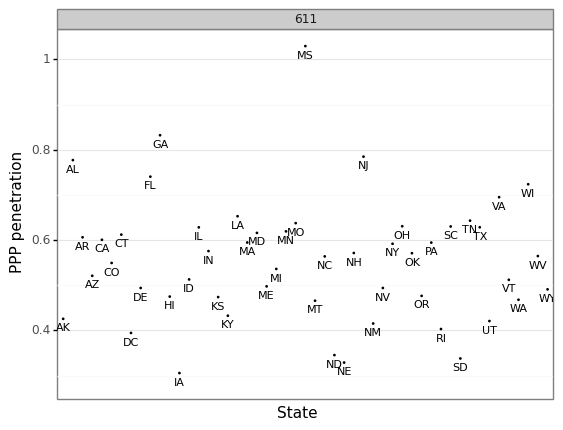

<ggplot: (8766418713325)>

In [ ]:
ggplot(dfq, aes(x='State', y='penetration', label='State')
    ) + facet_wrap('~ NAICS3', ncol=1 
    ) + geom_point( shape='o', size=0.1
    ) + geom_text( size=8, nudge_y=-0.02 #adjust_text=adjust_text_dict
    ) + scale_y_continuous(breaks=np.linspace(0,1,6)  #
    ) + ylab( 'PPP penetration'
#    ) + scale_x_discrete(name=' '
    ) + theme_bw(
    ) + theme( axis_ticks_major_x=element_blank(), axis_text_x=element_blank(), panel_grid_major_x = element_blank() )

####  Summaries

In [ ]:
print(scope, 'Total Number of PPP loans:', loans.shape[0])
print(scope, 'Total Number of PPP loans, excluding ' + ''.join(soleprop) 
                                                  + ': ' + str(loansc.shape[0]))
print(scope, 'Previous Number excluding loans with missing info: ' 
                                                  + str(pen['NLoans'].sum()))
print(scope, 'BLS Total Count of businesses: ' + str(pen['NEstabs'].sum()))
print(scope, 'Total Number of County-NAICS pairs with existing businesses: ' 
                                                  + str(pen.shape[0]))
print(scope, 'Previous Number with penetration > 1: ' + str(sum(pen['penetration'].gt(1))))
print(scope, 'Previous Number with penetration = 0: ' + str(sum(pen['penetration'].eq(0))))

### Correlation of LoanAmount with weekly wage

#### Overall median loan and wage

In [ ]:
print(scope, 'Average Total Quarterly Wages per Establishment: {0:,.0f}'.format(
                                     pen['total_qtrly_wages'].sum() / pen['NEstabs'].sum() ))
print(scope, 'Average Loan Amount: {0:,.0f}'.format( pen['TotLoanAmount'].sum() 
                                                         / pen['NLoans'].sum() ))
print(scope, 'Median Total Quarterly Wages per Establishment: {0:,.0f}'.format( 
                                     pen['TotQtrWagesperEstab'].median() ))
print(scope, 'Median Loan Amount: {0:,.0f}'.format( pen['AvgLoanAmount'].median() ))

#### distribution of total_qtrly_wages per NAICS

In [ ]:
dfq = pen[[naics,'TotQtrWagesperEstab']].groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='TotQtrWagesperEstab')
dfq.index = dfq.index.map(str)
print('     Quantiles (Total Quarterly Wages per Establishment per county)')
print('     ')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',0):  # more options can be specified also
    print(dfq.transpose())

#### distribution of AvgLoanAmount per NAICS

In [ ]:
dfq = pen[[naics,'AvgLoanAmount']].groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='AvgLoanAmount')
dfq.index = dfq.index.map(str)
print('     Quantiles (Average Loan Amount per county)')
print('     ')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',0):  # more options can be specified also
    print(dfq.transpose())

#### Scatterplot of Loan Amount vs wage

In [ ]:
ggplot(pen[pen['TotQtrWagesperEstab'] > 0], aes(x='logTotQtrWagesperEstab', y='logAvgLoanAmount')
    ) + facet_wrap('~ Region', scales='free'  #, nrow=2 
    ) + geom_point( size=0.1, alpha=0.1
#    ) + coord_trans( x="log", y="log"
    ) + xlab('Total Quarterly Wages per Establishment (log)'
    ) + ylab('Average Loan Amount (log)')

In [ ]:
tmp = pen[pen['Region'].ne(0) & pen['AvgLoanAmount'].gt(0) & pen['TotQtrWagesperEstab'].gt(0)
           ][['logAvgLoanAmount','logTotQtrWagesperEstab','NAICS2','Region']]
olsdf = pd.concat((tmp, 
             pd.get_dummies(tmp['NAICS2'], prefix='NAICS', drop_first=False),
             pd.get_dummies(tmp['Region'], prefix='Region', drop_first=False)), axis=1)
y = olsdf['logAvgLoanAmount']
# X: remove dependent var, columns transformed to dummies, and columns to drop to avoid perfect collinearity
X = olsdf.drop(columns=['logAvgLoanAmount','NAICS2','Region','NAICS_72','Region_1'])
X = sm.add_constant(X)   # add column for intercept

In [ ]:
mod = sm.OLS(y, X)    # Describe model
res = mod.fit()       # Fit model
print(res.summary())

from https://www.statsmodels.org/devel/gettingstarted.html: 

In [ ]:
sm.stats.linear_rainbow(res)

In [ ]:
sm.graphics.plot_partregress(endog='logAvgLoanAmount', exog_i='logTotQtrWagesperEstab'
                             , exog_others=['NAICS2','Region'], data=olsdf, obs_labels=False)

# SUPPLEMENTARY INFORMATION

In [ ]:
distribution of NLoans per NAICS

In [ ]:
ggplot(loansum.reset_index(), aes(x=naics, y='NLoans')
    ) + geom_boxplot(
#    ) + scale_y_log10(labels=lambda l: ["%d" % v for v in l]
    ) + coord_cartesian(ylim=[0, 100]
    ) + theme(axis_text_x=element_text(rotation=90, hjust=0.5)
    ) + ggtitle(scope + ' Number of loans per county' 
    ) + xlab('Industry (2-digit NAICS code)'
    ) + ylab('Number of Loans')

In [ ]:
dfq = loansum['NLoans'].reset_index().groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='NLoans')
dfq.index = dfq.index.map(str)
print('            Quantiles (Number of Loans per state)')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',0):  # more options can be specified also
    print(dfq.transpose())

##### distribution of avg_wkly_wage per NAICS

In [ ]:
ggplot(pen, aes(x=naics, y='avg_wkly_wage')
    ) + geom_boxplot(
    ) + coord_cartesian(ylim=[0, 2000]
    ) + theme(axis_text_x=element_text(rotation=90, hjust=0.5)
    ) + ggtitle('Average Weekly Wage per county'
    ) + xlab('Industry (2-digit NAICS code)'
    ) + ylab('Average Weekly Wage')

#### Scatterplot of Loan Amount vs wage

In [ ]:
ggplot(pen[pen['avg_wkly_wage'] > 0], aes(x='avg_wkly_wage', y='AvgLoanAmount')
      ) + facet_wrap('~ NAICS2', scales='free'  #, nrow=2 
    ) + geom_point( size=0.1, alpha=0.1
    ) + coord_trans( x="log2", y="log2"
    ) + xlab('Average Weekly Wage'
    ) + ylab('Average Loan Amount')

##### distribution of NEstabs per NAICS

In [ ]:
ggplot(pen, aes(x=naics, y='NEstabs')
    ) + geom_boxplot(
    ) + coord_cartesian(ylim=[0, 1200]
    ) + theme(axis_text_x=element_text(rotation=90, hjust=0.5)
    ) + ggtitle('Number of businesses per county'
    ) + xlab('Industry (2-digit NAICS code)'
    ) + ylab('Number of Businesses')

In [ ]:
dfq = pen[[naics,'NEstabs']].groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='NEstabs')
dfq.index = dfq.index.map(str)
print('     Quantiles (Number of businesses per county)')
print('     ')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',0):  # more options can be specified also
    print(dfq.transpose())

#### distribution of penetration per NAICS

In [ ]:
ggplot(pen, aes(x=naics, y='penetration')
    ) + geom_boxplot(
    ) + coord_cartesian(ylim=[0, 1.5]
    ) + theme(axis_text_x=element_text(rotation=90, hjust=0.5)
    ) + ggtitle(scope + ' Penetration per county'
    ) + xlab('Industry (2-digit NAICS code)'
    ) + ylab('Penetration (Num loans/Num BLS businesses)')

In [ ]:
dfq = pen[[naics,'penetration']].groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='penetration')
dfq.index = dfq.index.map(str)
print('           Quantiles (Penetration per county)')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',2):  # more options can be specified also
    print(dfq.transpose())

#### LoanAmount per business per NAICS

In [ ]:
ggplot(pen, aes(x=naics, y='AvgLoanAmount')
    ) + geom_boxplot(
    ) + coord_cartesian(ylim=[0, 3e5]
    ) + theme(axis_text_x=element_text(rotation=90, hjust=0.5)
    ) + ggtitle(scope + ' Average Loan Amount per county'
    ) + xlab('Industry (2-digit NAICS code)'
    ) + ylab('Average Loan Amount of loan'
    ) + scale_y_continuous(labels=lambda l: [f"{v:,.0f}" for v in l])

In [ ]:
dfq = pen[[naics,'AvgLoanAmount']].groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='AvgLoanAmount')
dfq.index = dfq.index.map(str)
print('           Quantiles (Average Loan Amount per county)')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',2):  # more options can be specified also
    print(dfq.transpose())

#### LoanAmount per Job per NAICS

In [ ]:
ggplot(pen, aes(x=naics, y='LoanAmtperEmp')
    ) + geom_boxplot(
    ) + coord_cartesian(ylim=[0, 2e4]
    ) + theme(axis_text_x=element_text(rotation=90, hjust=0.5)
    ) + ggtitle(scope + ' Loan Amount per job per county'
    ) + xlab('Industry (2-digit NAICS code)'
    ) + ylab('Loan Amount per job'
    ) + scale_y_continuous(labels=lambda l: [f"{v:,.0f}" for v in l])

In [ ]:
dfq = pen[[naics,'LoanAmtperEmp']].groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='LoanAmtperEmp')
dfq.index = dfq.index.map(str)
print('           Quantiles (Loan Amount per job per county)')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',2):  # more options can be specified also
    print(dfq.transpose())

#### total per NAICS

In [ ]:
dfp = pen.groupby([naics,'NAICSdescr']).agg('sum').reset_index()
dfp['penetration'] = dfp['NLoans'] / dfp['NEstabs']

ggplot(dfp, aes(x='reorder(NAICSdescr,penetration)', y='penetration')
          ) + geom_bar(stat="identity"
          ) + xlab('NAICS 2 Digit Sector'
          ) + ylab('PPP Loan Penetration'
          ) + ggtitle('New England PPP Penetrations per NAICS Sector'
#          ) + scale_y_continuous(trans = 'log2'
          ) + coord_flip()

In [ ]:
ggplot(dfp[dfp['penetration'].gt(1)], aes(x='reorder(NAICSdescr,penetration)', y='penetration')
          ) + geom_bar(stat="identity"
          ) + xlab(naics + ' Sector'
          ) + ylab('PPP Loan Penetration'
          ) + ggtitle('New England PPP Penetrations > 1 per NAICS Sector'
#          ) + scale_y_continuous(trans = 'log2'
          ) + coord_flip()

#### Histogram of County-NAICS penetrations

In [ ]:
ggplot(pen[pen.penetration.le(1)], aes(x='penetration')
       ) + geom_histogram(binwidth=.05
       ) + xlab('PPP Loan Penetration'
       ) + ylab('Number of Counties-Sectors'
       ) + ggtitle('Distribution of PPP Penetration <= 1 in New England')

#### outlier penetrations

In [ ]:
ggplot(pen, aes(x='State', y='penetration')
       ) + geom_boxplot(
       ) + xlab('State'
       ) + ylab('Penetration'
       ) + ggtitle('Outliers of PPP Penetration in New England')

#with pd.ExcelWriter(fpath + 'PPP.xlsx') as writer:
#    dfsum[['State','City','Zip','NAICS3','NAICSdescr','TotalAmount','NumLoans'
#           ,'JobsReported']].to_excel(writer, sheet_name='PPP', index=False)

#### Save for SBA paper

In [ ]:
with pd.ExcelWriter(fpath + 'SBApaperPPPpenetBLS_County_' + naics + scope + '.xlsx') as writer:
    pen[['State','COUNTYfips','COUNTYName',naics,'NAICSdescr','NEstabs','total_qtrly_wages','avg_wkly_wage','NLoans'
              ,'penetration','AvgLoanAmount','AvgJobsReported','LoanAmtperEmp']
                            ].to_excel(writer, sheet_name='PPP', index=False)

# debug
with pd.ExcelWriter('/Users/aligo/Downloads/tmp/ppp_loans_bls_counts.xlsx') as writer:
#    loansc.reset_index().to_excel(writer, sheet_name='loans')
    cnt.reset_index().to_excel(writer, sheet_name='bls')